# Classification Tasks with Time Series from Emteq PRO Mask in Head-Mounted Displays

---
## Statistical Analysis and Feature-based Classification

Check `01_...ipynb` to see details of the pipeline

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # For .py
    this_path = str(os.path.dirname(os.path.abspath(__file__))) #str(Path().absolute())+"/" # str(os.path.dirname(__file__))
except: # For .ipynb
    this_path = str(Path().absolute())+"/" #str(Path().absolute())+"/" # str(os.path.dirname(__file__))
print("File Path:", this_path)
sys.path.append(os.path.join(this_path, "kinemats"))

# Import classes
import utils  # Utils for generation of files and paths
import quaternion_math

from plotter.ts_visualization import *
import ts_processing
import ts_classification

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#%matplotlib inline
import matplotlib.pyplot as plt

# Statistical tests
import scipy.stats as stats

# Feature based classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


File Path: e:\dsv\dev\git_repos\explainable-time-series/


---
# SETUP

In [2]:
# CONSTANTS
import experiment_config
from experiment_config import Datasets, DataRepresentation, Classifiers
from ts_classification import EnumDistMetrics

# All the files generated from this notebook are in a subfolder with this name
NOTEBOOK_SUBFOLDER_NAME = '2_FeatureBasedClassifiers/'

#### NOTE: This dictionary is reassigned later in the code whenever the datasets are generated.
DICT_DATA = {
    DataRepresentation.Quaternion:  None,
    DataRepresentation.Euler:       None,
    DataRepresentation.Yaw:         None,
    DataRepresentation.All:         None,
}
# Dictionary to convert a datarepresentation into a num - To be stored in the numpy array for results
DICT_DATA_TO_NUM = { k:i for i,k in enumerate(DICT_DATA.keys())}

# Setup of overlapping windows to extract features from time series
SAMPLING_PERIOD_TS = 1 # seconds

#### Classification methods to apply.
DICT_CLASSIFIERS = {
    "KNN":    KNeighborsClassifier(n_neighbors=experiment_config.KNN_N_NEIGH),
    "DT":     DecisionTreeClassifier(max_depth=experiment_config.DT_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    "RF":     RandomForestClassifier(n_estimators=experiment_config.RF_N_ESTIMATORS, max_depth=experiment_config.RF_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    "GBM":    GradientBoostingClassifier(n_estimators=experiment_config.GBM_N_ESTIMATORS, max_depth=experiment_config.GBM_MAX_DEPTH, criterion='friedman_mse', random_state=experiment_config.MC_RANDOM_SEED)
}

## K-Fold partition
N_SPLITS_CV = experiment_config.CV_NUM_FOLDS # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]


##########################
### CLASSIFIERS
##########################

# Classes: Which column from the demographics.csv is used as target class label
CLASS_COLUMN_NAME = "videoId" #"user"  # "videoId": Tries to classify the videos. "user" tries to classify the people.

#### FEATURE-BASED CLASSIFIERS CLASSIFIERS SETUP

MC_RANDOM_SEED = 1234
CV_NUM_FOLDS = 10

# KNN
KNN_N_NEIGH = 9
# DT
DT_MAX_DEPTH = 100
# RF
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 10
# GBM
GBM_N_ESTIMATORS = 50
GBM_MAX_DEPTH = 5


#### STATE-OF-THE-ART CLASSIFIERS SETUP

# KNN-TS
KNN_TS_N_NEIGH = Classifiers.KNN_1
KNN_TS_DTW_WARPING_WINDOW = 0.05

# Mr-SEQL (Multivariate)
# No params required

# STSF (Univariate)
STSF_N_ESTIMATORS = 200

# TDE (Multivariate)
TDE_MAX_TIME = 5
TDE_MAX_ENSEMBLE_SIZE = 50
TDE_MAX_SELECTED_PARAMS = 50

# ROCKET (Multivariate)
ROCKET_N_KERNELS = 10000

# MiniRocket (Multivariate)
MINIROCKET_N_KERNELS = 10000
MINIROCKET_MAX_DILATIONS = 32


---
# UTILITY FUNCTIONS

Generate paths to write output files

In [3]:
STR_DATASET = str(experiment_config.DATASET_MAIN)+"/"
print(STR_DATASET)
def gen_path_plot(filename):
    # Generates full paths for PLOTS just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.PLOT_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME, \
                                        file_extension=experiment_config.IMG_FORMAT, save_files=experiment_config.EXPORT_PLOTS)

def gen_path_temp(filename, subfolders="", extension=experiment_config.TEMP_FORMAT):
    # Generates full paths for TEMP FILES just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.TEMP_FOLDER, \
                                        subfolders=STR_DATASET+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.RESULTS_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME+subfolders, \
                                        file_extension=extension)

ETL2/


# DATASETS: Load and preprocess


In [4]:
print("\t>>>LOADING DATASETS")
dataset = None
classes = None

	>>>LOADING DATASETS


In [5]:
if experiment_config.DATASET_MAIN == Datasets.ETL2:
    
    DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Dataset_ETL2_postprocessed", extension=".csv")
    print(DATASET_POSTPROCESSED_FILENAME)
    dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME, index_col=[0,1,2])
    # dataset.VideoID.fillna(-1,inplace=True) # The VideoID in resting stages is NaN, replace with -1 

./temp/ETL2/Dataset_ETL2_postprocessed.csv


### General variables to access dataset

In [6]:

# Choose data from the experimental sessions
# classes_mapping = {
#             "VideoNegative": -1,
#             "VideoNeutral": 0,
#             "VideoPositive": 1,
#             }

# # # Filter experimental stages (skip resting)
# # Q = ( dataset.Stage.isin( ["VideoNegative","VideoNeutral","VideoPositive"] ) )
# Q = ( dataset.Stage.isin( list(classes_mapping.keys()) ) )
# dataset = dataset[ Q ]
# classes = dataset.Stage.map(classes_mapping)

In [7]:
participants_ids = dataset.index.get_level_values(0).unique()
participants_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64', name='Participant')

In [8]:
experiment_segment_names = dataset.index.get_level_values(1).unique()
experiment_segment_names

Index(['VideoNegative', 'Resting_VideoNegative', 'VideoPositive',
       'Resting_VideoPositive', 'VideoNeutral', 'Resting_VideoNeutral'],
      dtype='object', name='Stage')

In [9]:
video_ids = dataset.VideoID.unique()
video_ids
# NaN refers to the resting stages

array([18., 20.,  4.,  3., 12., 19., 13.,  6., 10.,  5., nan, 51., 41.,
       55., 42., 56., 58., 46., 49., 48., 57., 39., 33., 23., 25., 29.,
       31., 22., 38., 21., 37.])

In [10]:
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])

    # Iterate over all participants to see the ids that they were watching
    # DO ALL PARTICIPANTS WATCH THE SAME VIDEOS????
    for participant in participants_ids:
        vid_ids = dataset.loc[(participant,segment)].VideoID.values
        video_ids_per_segment[segment] = np.concatenate( [ video_ids_per_segment[segment], vid_ids ]) 

    # Keep unique video ids
    video_ids_per_segment[segment] = np.unique(video_ids_per_segment[segment])

video_ids_per_segment

e:\dsv\dev\git_repos\explainable-time-series\env\lib\site-packages\ipykernel_launcher.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  


{'VideoNegative': array([ 3.,  4.,  5.,  6., 10., 12., 13., 18., 19., 20.]),
 'Resting_VideoNegative': array([nan]),
 'VideoPositive': array([41., 42., 46., 48., 49., 51., 55., 56., 57., 58.]),
 'Resting_VideoPositive': array([nan]),
 'VideoNeutral': array([21., 22., 23., 25., 29., 31., 33., 37., 38., 39.]),
 'Resting_VideoNeutral': array([nan])}

In [11]:
# Used to define the segments of interest and the mapping for classifiers
CLASSES_MAPPING = {
            "VideoNegative": -1,
            "VideoNeutral": 0,
            "VideoPositive": 1,
            }
CLASSES_MAPPING_INVERSE = { v:k for k,v in CLASSES_MAPPING.items()}

## EDA

In [12]:
participant = 0
segment = "VideoNegative"
video_id = video_ids_per_segment[segment][0] # Access the dictionary of videos existing in the segment, choose the first VideoID

# Select a whole experimental segment
single_segment_ts = dataset.loc[(participant,segment)]
# Select a specific video inside the experimental segment
single_video_ts = single_segment_ts[ single_segment_ts.VideoID == video_id]

e:\dsv\dev\git_repos\explainable-time-series\env\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

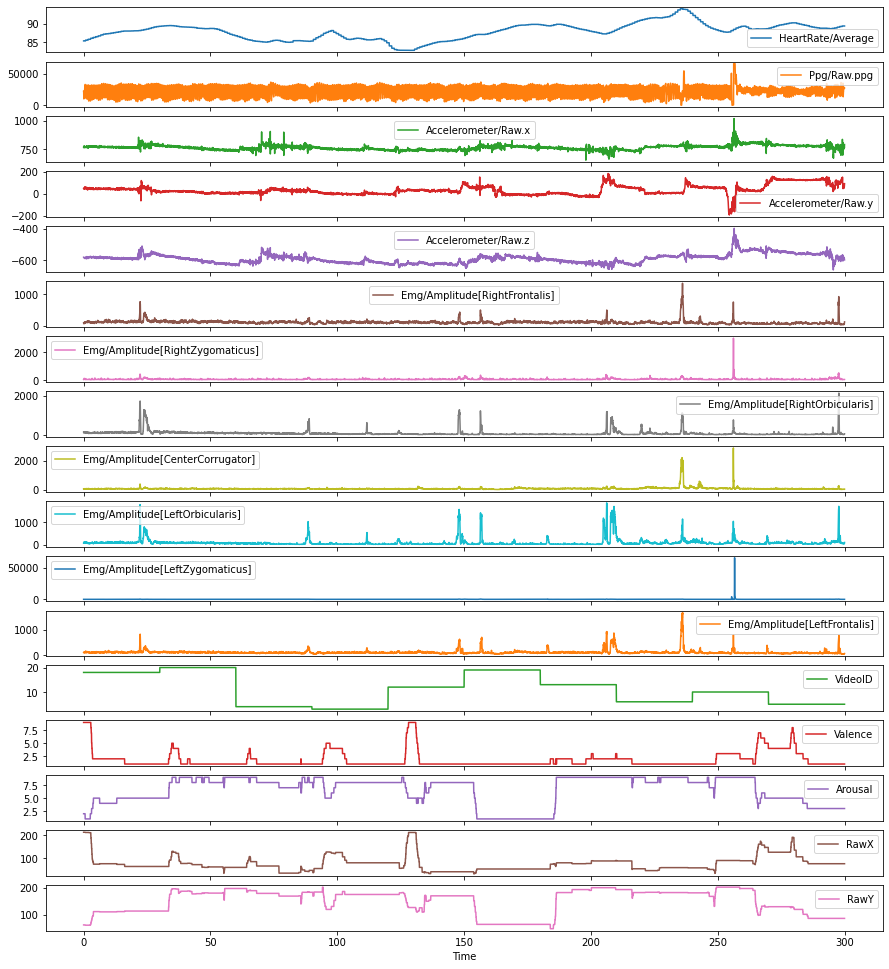

In [13]:
single_segment_ts.plot.line(subplots=True, figsize=(15,1*single_segment_ts.shape[1]), sharex=True)

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

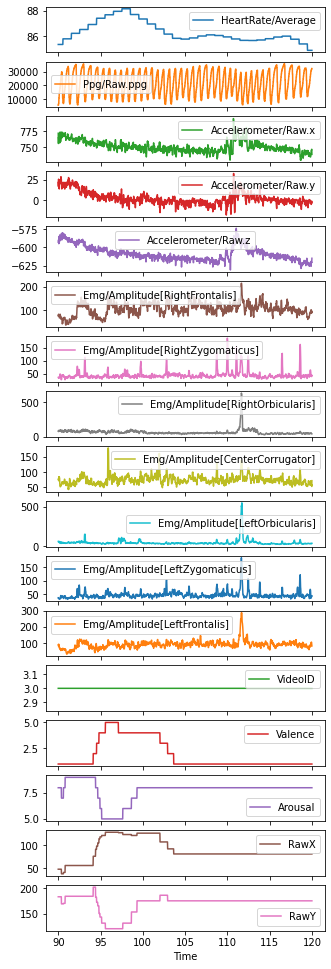

In [14]:
single_video_ts.plot.line(subplots=True, figsize=(5,1*single_video_ts.shape[1]), sharex=True)

## Analysis 0: Statistical Analysis of Subjective Self-reported Measures

Validate whether the average self-reported **valence** measures differ between video categories aiming to induce `Negative`, `Neutral`, and `Positive` emotions.

**Method:** Paired t-test to compare the mean of two samples.

### Generate a table with the average self-reported ratings per videoId, grouped by segment

In [15]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
STATISTICAL_TESTS_FILENAME = gen_path_results("1_AverageSelfReportedEmotions", extension=".csv")

# Load or create dataframe with statistics of initial dataset
df_results = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [STATISTICAL_TESTS_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        for segment in experiment_segment_names:
            # Only valid experimental sessions (no resting)
            if segment in list(CLASSES_MAPPING.keys()): 
                # Iterate all videos from the segment
                for video_id in video_ids_per_segment[segment]:
                    dict_this_result = {
                                        "videoId": [video_id],
                                        "participant": [],
                                        "avg_Valence_"+str(segment): np.array([]),
                                        "avg_RawX_"+str(segment): np.array([]),
                                        "avg_Arousal_"+str(segment): np.array([]),
                                        "avg_RawY_"+str(segment): np.array([]),
                                        }
                    
                    # Load and average the data from each participant per video
                    for participant in participants_ids:
                        single_segment_ts = dataset.loc[(participant,segment)]
                        single_video_ts = single_segment_ts[ single_segment_ts.VideoID == video_id]

                        dict_this_result["participant"] = participant
                        dict_this_result["avg_Valence_"+str(segment)] = single_video_ts.Valence.values.mean()
                        dict_this_result["avg_RawX_"+str(segment)] =    single_video_ts.RawX.values.mean()
                        dict_this_result["avg_Arousal_"+str(segment)] = single_video_ts.Arousal.values.mean()
                        dict_this_result["avg_RawY_"+str(segment)] =    single_video_ts.RawY.values.mean()
                
                        df_this_result = pd.DataFrame(dict_this_result)

                        # Append to the main dataframe with the results 
                        df_results = df_this_result if (df_results is None) else pd.concat([df_results, df_this_result])

        # print(df_results)

        # Saving .csv
        df_results.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

Trying 1/3 to load files: ['./results/ETL2/2_FeatureBasedClassifiers/1_AverageSelfReportedEmotions.csv']
File ./results/ETL2/2_FeatureBasedClassifiers/1_AverageSelfReportedEmotions.csv was successfully loaded


In [16]:
df_results.head()

,videoId,participant,avg_Valence_VideoNegative,avg_RawX_VideoNegative,avg_Arousal_VideoNegative,avg_RawY_VideoNegative,avg_Valence_VideoPositive,avg_RawX_VideoPositive,avg_Arousal_VideoPositive,avg_RawY_VideoPositive,avg_Valence_VideoNeutral,avg_RawX_VideoNeutral,avg_Arousal_VideoNeutral,avg_RawY_VideoNeutral
0,3.0,0,1.888741,88.991339,7.750167,169.853431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,1,3.552965,104.920720,5.762159,137.229181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2,3.440961,112.131421,4.304203,105.605070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3,1.018000,49.537333,6.446667,155.638000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,4,2.265646,80.373502,7.316911,161.449401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_results_per_participant = df_results.groupby("participant").mean().reset_index().drop("videoId", axis=1)
df_results_per_participant[ ["avg_RawX_VideoNegative","avg_RawX_VideoNeutral","avg_RawX_VideoPositive"]]

,avg_RawX_VideoNegative,avg_RawX_VideoNeutral,avg_RawX_VideoPositive
0,76.427720,163.897664,198.261996
1,92.015252,156.821964,172.623237
2,93.726026,150.339353,182.907080
3,67.994330,147.141278,183.503476
4,84.311065,144.067951,163.561335
5,97.268663,154.651290,164.510005
6,82.461577,107.361631,194.071524
7,102.893589,142.756062,168.848289
8,78.368479,141.227611,161.888142
9,100.447080,136.738575,157.318229


We analyze `RawX` instead of `Valence` because it contains the raw reported values from the joystick and has not been quantisized in the `9-level` variable of valence.

In [18]:
# Separate columns for statistical test
subj_valence_videos_neg = df_results_per_participant.avg_RawX_VideoNegative
subj_valence_videos_ntr = df_results_per_participant.avg_RawX_VideoNeutral
subj_valence_videos_pos = df_results_per_participant.avg_RawX_VideoPositive

In [134]:
print(f"Negative: \t{subj_valence_videos_neg.mean()} +/- ({subj_valence_videos_neg.std()})")
print(f"Neutral: \t{subj_valence_videos_ntr.mean()} +/- ({subj_valence_videos_ntr.std()})")
print(f"Positive: \t{subj_valence_videos_pos.mean()} +/- ({subj_valence_videos_pos.std()})")

Negative: 	92.6765464193072 +/- (13.476894628658625)
Neutral: 	142.6777268967662 +/- (13.27984260967597)
Positive: 	176.31764152645272 +/- (15.27956445800135)


$H_0: \mu_- \geq \mu_N$

$H_1: \mu_- < \mu_N$, if $p<0.01$, we reject the null hypothesis that the mean **reported valence** in the `Negative` videos $\mu_-$ is *greater or equal*  than in the `Neutral` videos $\mu_N$

In [19]:
# Statistical test: paired t-test
test1 = stats.ttest_rel(subj_valence_videos_neg, subj_valence_videos_ntr, alternative="less")
print(test1)

Ttest_relResult(statistic=-9.926278389753774, pvalue=5.118620916842127e-08)


$H_0: \mu_+ \leq \mu_N$

$H_1: \mu_+ > \mu_N$, if $p<0.01$, we reject the null hypothesis that the mean **reported valence** in the `Positive` videos $\mu_-$ is *lower or equal* than in the `Neutral` videos $\mu_N$

In [20]:
test2 = stats.ttest_rel(subj_valence_videos_pos, subj_valence_videos_ntr, alternative="greater")
print(test2)

Ttest_relResult(statistic=6.533422513652992, pvalue=6.633521607346729e-06)


In [21]:
save_path_text = gen_path_results("1_AverageSelfReportedEmotion_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: Negative greater or equal than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: Positive lower or equal than Neutral:\t" + str(test2) + "\n")
f.close()

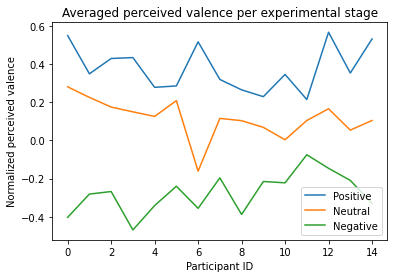

In [22]:
save_path_plot = gen_path_results("1_AverageSelfReportedEmotion", extension=".png")

# Line plot of perceived valence per participant
df_avg_valence_segment = df_results.groupby("participant").mean().reset_index().drop("videoId", axis=1)[ ["avg_RawX_VideoNegative","avg_RawX_VideoNeutral","avg_RawX_VideoPositive"] ]
# Formatting
df_avg_valence_segment.columns = ["Negative", "Neutral", "Positive"]
df_avg_valence_segment = df_avg_valence_segment[ ["Positive", "Neutral", "Negative"] ]
df_avg_valence_segment -= 128
df_avg_valence_segment /= 128
ax = df_avg_valence_segment.plot.line(xlabel="Participant ID", 
                                        ylabel="Normalized perceived valence", 
                                        title="Averaged perceived valence per experimental stage", 
                                        figsize=(6,4))
ax.figure.savefig(save_path_plot)

---
## Analysis 1: Feature-based classification assuming independent samples


Apply downsampling with non-overlapping windows to all participants, relevant segments, and each video

In [23]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
DATASET_FEATURE_BASED_FILENAME = gen_path_temp("Dataset_ETL2_FeatureBasedClassifiers_1Hz", extension=".csv")

# Subsample without overlapping window
SAMPLING_PERIOD_TS = SAMPLING_PERIOD_TS # Seconds

# Load or create dataframe
dataset_featured_based = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [DATASET_FEATURE_BASED_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        dataset_featured_based = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        # All participants in the dataset
        for participant in participants_ids:
            for segment in experiment_segment_names:
                # Only valid experimental sessions (no resting)
                if segment in list(CLASSES_MAPPING.keys()): 
                    # Load all TS from the segment
                    single_segment_ts = dataset.loc[(participant,segment)]

                    videos_in_segment = single_segment_ts.VideoID.unique()
                    videos_in_segment

                    # Iterate over all the videos in side the specific segment
                    for video_id in videos_in_segment:
                        single_video_ts = single_segment_ts[ single_segment_ts.VideoID == video_id]
                        single_video_ts.index = pd.to_datetime(single_video_ts.index, unit="s")

                        # Average without 
                        single_video_ts = single_video_ts.resample(str(SAMPLING_PERIOD_TS)+'S', origin='start').mean()
                        single_video_ts.index = (single_video_ts.index - single_video_ts.index[0]).total_seconds()
                        
                        # Create DF with independent samples
                        df_this_result = single_video_ts.reset_index()
                        df_this_result["participant"] = participant
                        df_this_result["Segment"] = segment

                        # print(f"P:{participant}\tS:{segment}\tTS:{single_video_ts.shape}")

                        # Append to the main dataframe with the results 
                        dataset_featured_based = df_this_result if (dataset_featured_based is None) else pd.concat([dataset_featured_based, df_this_result])

        print(dataset_featured_based.shape)

        # Saving .csv
        dataset_featured_based.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

Trying 1/3 to load files: ['./temp/ETL2/Dataset_ETL2_FeatureBasedClassifiers_1Hz.csv']
File ./temp/ETL2/Dataset_ETL2_FeatureBasedClassifiers_1Hz.csv was successfully loaded


In [24]:
dataset_featured_based.head()

,Time,HeartRate/Average,Ppg/Raw.ppg,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],VideoID,Valence,Arousal,RawX,RawY,participant,Segment
0,0.0,85.4604,19713.92,768.68,50.62,-583.34,98.50,62.98,136.36,68.42,108.24,58.96,108.96,18.0,9.00,1.58,213.58,62.58,0,VideoNegative
1,1.0,85.6728,21671.68,768.70,46.68,-582.96,123.86,42.54,127.92,80.20,93.00,44.34,110.84,18.0,9.00,1.00,213.00,62.00,0,VideoNegative
2,2.0,85.9048,17402.88,772.28,47.30,-579.00,119.58,44.68,108.50,74.50,75.16,47.54,97.42,18.0,8.82,1.38,208.04,63.98,0,VideoNegative
3,3.0,86.1628,20697.60,771.20,46.18,-579.92,100.48,50.32,107.46,68.48,84.68,49.34,95.74,18.0,3.34,3.40,106.36,92.66,0,VideoNegative
4,4.0,86.3820,21237.76,770.32,45.00,-580.74,109.14,56.14,118.88,70.76,94.40,52.72,107.66,18.0,2.00,5.00,75.00,112.00,0,VideoNegative


### Classification

`TODO:` Change the columns to drop. Select meaningful features.

In [25]:
COLUMNS_TO_DROP = ["Time", "VideoID", "participant", "Valence", "Arousal", "RawX", "RawY"]
dataset = dataset_featured_based.drop(COLUMNS_TO_DROP, axis=1)

dataset.rename(columns={"Segment":"Target"}, inplace=True)
dataset["Target"] = dataset["Target"].map(CLASSES_MAPPING)

dataset.head()

,HeartRate/Average,Ppg/Raw.ppg,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Target
0,85.4604,19713.92,768.68,50.62,-583.34,98.50,62.98,136.36,68.42,108.24,58.96,108.96,-1
1,85.6728,21671.68,768.70,46.68,-582.96,123.86,42.54,127.92,80.20,93.00,44.34,110.84,-1
2,85.9048,17402.88,772.28,47.30,-579.00,119.58,44.68,108.50,74.50,75.16,47.54,97.42,-1
3,86.1628,20697.60,771.20,46.18,-579.92,100.48,50.32,107.46,68.48,84.68,49.34,95.74,-1
4,86.3820,21237.76,770.32,45.00,-580.74,109.14,56.14,118.88,70.76,94.40,52.72,107.66,-1


<AxesSubplot:>

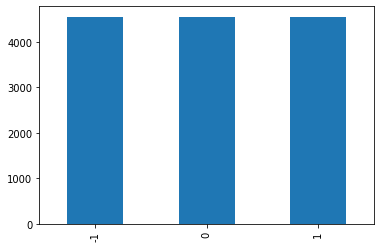

In [26]:
# Class imbalance
dataset["Target"].value_counts().plot.bar()

In [27]:
# Split DATA and LABELS
data_X = dataset.drop("Target", axis=1)
data_y = dataset["Target"]

data_colnames = data_X.columns.values

print(f"X:{data_X.shape}, y:{data_y.shape}\nColumns:{data_colnames}")

X:(13638, 12), y:(13638,)
Columns:['HeartRate/Average' 'Ppg/Raw.ppg' 'Accelerometer/Raw.x'
 'Accelerometer/Raw.y' 'Accelerometer/Raw.z'
 'Emg/Amplitude[RightFrontalis]' 'Emg/Amplitude[RightZygomaticus]'
 'Emg/Amplitude[RightOrbicularis]' 'Emg/Amplitude[CenterCorrugator]'
 'Emg/Amplitude[LeftOrbicularis]' 'Emg/Amplitude[LeftZygomaticus]'
 'Emg/Amplitude[LeftFrontalis]']


In [28]:
# Train-test split
X = data_X.values
y = data_y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=experiment_config.MC_RANDOM_SEED, stratify=y)
print(f"Train>> X:{X_train.shape}, y:{y_train.shape} \t Test>> X:{X_test.shape}, y:{y_test.shape}")

Train>> X:(10910, 12), y:(10910,) 	 Test>> X:(2728, 12), y:(2728,)


In [29]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("2_ResultsPerFold_FeatureBasedClassification", extension=".csv")

# Load or create dataframe
results_evaluation = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        results_evaluation = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        #### ITERATION FOR THE EXPERIMENT

        # # Apply StratifiedGroupKFold scheme to preserve class imbalance and groups per participant
        # from sklearn.model_selection import StratifiedGroupKFold
        # sgkf = StratifiedGroupKFold(N_SPLITS_CV, random_state=experiment_config.MC_RANDOM_SEED)

        # Evaluate
        for name, classifier in DICT_CLASSIFIERS.items():
            print(f"Currently training the classifier {name}.")

            # Get the evaluation metrics per fold after cross-validation
            # Note that we are passing the normalized array `data_X_norm` to all classifiers
            scores_cv = cross_validate(classifier, X_train, y_train, cv=N_SPLITS_CV, scoring=SCORING_METRICS)

            #### Generate the results to populate the pandas.DataFrame
            df_this_result = pd.DataFrame(scores_cv)
            df_this_result["classifier_name"] = name
            df_this_result["fold"] = np.arange(N_SPLITS_CV)

            # Append to the main dataframe with the results 
            results_evaluation = df_this_result if (results_evaluation is None) else pd.concat([results_evaluation, df_this_result], ignore_index=True)

        print("The experimental setup has finished")

        # Saving .csv
        results_evaluation.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

Trying 1/3 to load files: ['./results/ETL2/2_FeatureBasedClassifiers/2_ResultsPerFold_FeatureBasedClassification.csv']
File ./results/ETL2/2_FeatureBasedClassifiers/2_ResultsPerFold_FeatureBasedClassification.csv was successfully loaded


In [30]:
results_evaluation

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,classifier_name,fold
0,0.027581,0.050341,0.633364,0.637266,0.633392,0.633952,KNN,0
1,0.025953,0.049617,0.615949,0.624677,0.615988,0.617832,KNN,1
2,0.025390,0.055892,0.628781,0.636050,0.628808,0.629843,KNN,2
3,0.025933,0.050688,0.645280,0.647209,0.645334,0.645935,KNN,3
4,0.025970,0.051809,0.604033,0.607530,0.604080,0.605250,KNN,4
5,0.025082,0.051449,0.631531,0.637856,0.631575,0.633573,KNN,5
6,0.025769,0.050795,0.661778,0.669691,0.661705,0.662959,KNN,6
7,0.025169,0.049845,0.607699,0.613663,0.607622,0.607985,KNN,7
8,0.025731,0.055406,0.659945,0.664727,0.659848,0.660146,KNN,8
9,0.025982,0.051655,0.604950,0.610155,0.604867,0.605486,KNN,9


In [31]:
# Group performance per classifier (mean+/-std)
df_mean = results_evaluation.groupby(by=["classifier_name"]).mean()
df_std = results_evaluation.groupby(by=["classifier_name"]).std()
df_mean

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,fold
classifier_name,,,,,,,
DT,0.192276,0.003055,0.837947,0.838135,0.837957,0.837873,4.5
GBM,8.042962,0.007443,0.866361,0.866462,0.866369,0.865918,4.5
KNN,0.025856,0.051750,0.629331,0.634882,0.629322,0.630296,4.5
RF,3.032248,0.026379,0.877910,0.879726,0.877918,0.877119,4.5


In [32]:
# Convert to a text
df_mean_str = df_mean.apply(lambda x: ['%.3f'%v for v in x.values])
df_std_str = df_std.apply(lambda x: ['%.2f'%v for v in x.values])

df_results = (df_mean_str + " (" + df_std_str + ")")

# Rename columns
df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
df_results.columns = ["accuracy","precision","recall","f1-score"]
df_results

,accuracy,precision,recall,f1-score
classifier_name,,,,
DT,0.838 (0.01),0.838 (0.01),0.838 (0.01),0.838 (0.01)
GBM,0.866 (0.01),0.866 (0.01),0.866 (0.01),0.866 (0.01)
KNN,0.629 (0.02),0.635 (0.02),0.629 (0.02),0.630 (0.02)
RF,0.878 (0.01),0.880 (0.01),0.878 (0.01),0.877 (0.01)


In [33]:
# Generate LaTeX table
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("2_ResultsPerFold_FeatureBasedClassification", extension=".tex")
df_results.to_latex(FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME)

Define below which is the best classifier, it will generate predictions on the final Test set

In [34]:
# DEFINE HERE THE BEST CLASSIFIER
BEST_CLASSIFIER = DICT_CLASSIFIERS["RF"]

# Fit in the whole training set
best_classifier = BEST_CLASSIFIER
best_classifier = best_classifier.fit(X_train, y_train)

# Classification on test set
y_true = y_test
y_pred = best_classifier.predict(X_test)


In [35]:
# Classificaiton report on TEST set
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.86      0.85       910
           0       0.91      0.79      0.85       909
           1       0.86      0.94      0.90       909

    accuracy                           0.87      2728
   macro avg       0.87      0.87      0.86      2728
weighted avg       0.87      0.87      0.86      2728



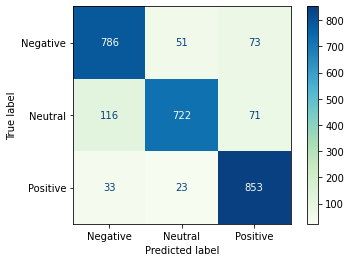

In [36]:
# Confusion Matrix
CLASS_NEW_NAMES = ["Negative","Neutral","Positive"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NEW_NAMES)
disp.plot(cmap="GnBu")

### Analysis 1B: Interpretability with LIME and SHAP

In [37]:
from lime import lime_tabular

In [38]:
print(list(y_true[:100]))
print(list(y_pred[:100]))
print(list( (y_true==y_pred)[:100] ))

[0, 1, 0, 1, -1, 1, -1, -1, -1, 0, 1, 1, 0, -1, 0, -1, 1, -1, -1, 0, 0, 1, 0, 1, 0, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 0, 1, -1, 1, 0, 1, 0, 0, 0, 0, -1, 0, 1, -1, -1, 0, 0, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 0, 0, -1, -1, 0, 1, 0, -1, -1, 1, -1, 1, -1, 0, 0, -1, 1, 1, 1, 0, 0, -1, -1, 1, 1, 0, 0, 0, -1, 1, -1, -1, 0, -1, 0, 0, 1]
[0, 1, 0, 1, -1, 1, -1, -1, -1, 0, 1, 1, 0, -1, 0, -1, 1, -1, -1, 0, -1, 1, 0, 1, 0, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 0, -1, 1, 1, 1, 0, 0, -1, 0, -1, 0, 1, -1, -1, 0, 0, 1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 1, 0, -1, -1, 0, 1, 0, -1, -1, 1, 0, 1, -1, 0, -1, -1, 1, 1, 1, 0, 0, -1, -1, 1, 1, 0, -1, 1, -1, 1, -1, -1, 0, -1, 0, 0, 1]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, True, False, True, True, True, False, True, True, True, True, True, True, Tru

In [39]:
# Configure LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train,
    feature_names = data_colnames,
    class_names = CLASS_NEW_NAMES,
    mode = "classification",
    random_state=experiment_config.MC_RANDOM_SEED
)

In [40]:
# Explanation
NUM_INSTANCE_TO_EXPLAIN = 0

In [41]:
# LIME
print("Preparing to explain instance with true label = ", y_test[NUM_INSTANCE_TO_EXPLAIN], "\t Available test instances:", y_test.shape)

explanation = explainer.explain_instance(
    data_row = X_test[NUM_INSTANCE_TO_EXPLAIN],
    top_labels = 1,
    predict_fn = best_classifier.predict_proba
)
explanation.show_in_notebook(show_table=True)

Preparing to explain instance with true label =  0 	 Available test instances: (2728,)


In [42]:
exp_dict = explanation.as_map()
exp_dict

{1: [(0, 0.04829132278781259),
  (9, -0.039627136230635206),
  (5, -0.03643985333010072),
  (4, 0.028854202180142632),
  (6, -0.024723792803447872),
  (10, -0.023782119379490655),
  (8, 0.021703397364045283),
  (2, 0.021620510892852867),
  (7, 0.010032035042921507),
  (11, -0.008450057213357719)]}

In [43]:
y_true_instance = y_test[NUM_INSTANCE_TO_EXPLAIN]
y_predicted_lime = [*exp_dict][0]
feat_importance_instance = exp_dict[y_predicted_lime]

dict_this_explanation = {
    "y_true": y_true_instance,
    "y_predicted_lime": y_predicted_lime - 1, # Predictions are {0,1,2} and true labels are {-1,0,1}
}

for feature_index, feature_importance in feat_importance_instance:
    print(f"{feature_index} Feature: {data_colnames[feature_index]} = {feature_importance}")

0 Feature: HeartRate/Average = 0.04829132278781259
9 Feature: Emg/Amplitude[LeftOrbicularis] = -0.039627136230635206
5 Feature: Emg/Amplitude[RightFrontalis] = -0.03643985333010072
4 Feature: Accelerometer/Raw.z = 0.028854202180142632
6 Feature: Emg/Amplitude[RightZygomaticus] = -0.024723792803447872
10 Feature: Emg/Amplitude[LeftZygomaticus] = -0.023782119379490655
8 Feature: Emg/Amplitude[CenterCorrugator] = 0.021703397364045283
2 Feature: Accelerometer/Raw.x = 0.021620510892852867
7 Feature: Emg/Amplitude[RightOrbicularis] = 0.010032035042921507
11 Feature: Emg/Amplitude[LeftFrontalis] = -0.008450057213357719


In [44]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
GENERAL_LIME_EXPLANATION_FILENAME = gen_path_results("2b_ResultsExplanation_LIME_PerInstance", extension=".csv")

# Load or create dataframe
results_explanation = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [GENERAL_LIME_EXPLANATION_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        results_explanation = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""
        
        for i in range(0,y_test.shape[0]):
            NUM_INSTANCE_TO_EXPLAIN = i

            # LIME
            # Execute explanation
            explanation = explainer.explain_instance(
                data_row = X_test[NUM_INSTANCE_TO_EXPLAIN],
                top_labels = 1,
                predict_fn = best_classifier.predict_proba
            )
            exp_dict = explanation.as_map()

            # Extract specific results from explanation
            y_true_instance = y_test[NUM_INSTANCE_TO_EXPLAIN]
            y_predicted_lime = [*exp_dict][0]
            dict_this_explanation = {
                "y_true": [y_true_instance],
                "y_predicted_lime": [y_predicted_lime-1], # Predictions are {0,1,2} and true labels are {-1,0,1}
            }

            print(f"Explaining instance {NUM_INSTANCE_TO_EXPLAIN}/{y_test.shape[0]-1} - y_true={y_true_instance}, y_pred={y_predicted_lime-1}")

            # Extract list of tuples with (feature_index, feature_importance)    
            feat_importance_instance = exp_dict[y_predicted_lime]

            for feature_index, importance_value in feat_importance_instance:
                dict_this_explanation[ data_colnames[feature_index] ] = [importance_value]
                # print(f"{feature_index} Feature: {data_colnames[feature_index]} = {feature_importance}")

            # Convert to DataFrame
            df_this_explanation = pd.DataFrame.from_dict(dict_this_explanation)

            results_explanation = df_this_explanation if (results_explanation is None) else pd.concat([results_explanation, df_this_explanation], ignore_index=True)

        results_explanation = results_explanation.reset_index()
        print(results_explanation.shape)

        # Saving .csv
        results_explanation.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

Trying 1/3 to load files: ['./results/ETL2/2_FeatureBasedClassifiers/2b_ResultsExplanation_LIME_PerInstance.csv']
File ./results/ETL2/2_FeatureBasedClassifiers/2b_ResultsExplanation_LIME_PerInstance.csv was successfully loaded


In [45]:
results_explanation

,index,y_true,y_predicted_lime,HeartRate/Average,Accelerometer/Raw.z,Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[RightFrontalis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[RightZygomaticus],Accelerometer/Raw.x,Emg/Amplitude[RightOrbicularis],Ppg/Raw.ppg,Emg/Amplitude[LeftFrontalis],Accelerometer/Raw.y
0,0,0,0,0.048454,0.034937,-0.033591,-0.029413,-0.028865,0.026140,-0.023692,0.021388,0.014458,0.013153,NaN,NaN
1,1,1,1,NaN,-0.025423,0.027322,0.050931,0.042747,0.163696,0.073485,-0.025508,0.003707,0.001037,0.047089,NaN
2,2,0,0,0.056325,-0.011145,-0.036642,NaN,0.041947,-0.061618,0.045749,-0.012705,-0.006590,NaN,0.012625,-0.013634
3,3,1,1,-0.009437,0.054046,0.052359,0.053676,0.035573,0.165309,0.071533,-0.024136,0.012202,NaN,0.037497,NaN
4,4,-1,-1,0.021994,NaN,-0.002716,-0.018039,-0.006864,-0.107341,0.084990,0.012309,-0.007445,NaN,-0.035368,0.007500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2723,0,0,0.051913,-0.008027,-0.044112,0.026032,0.048519,0.020872,0.049955,-0.018655,0.020962,NaN,0.021383,NaN
2724,2724,-1,-1,0.014136,-0.018318,0.023390,-0.021894,0.013374,0.054876,0.090145,-0.020720,0.018628,NaN,0.018765,NaN
2725,2725,0,0,-0.012478,0.026708,-0.023024,-0.004806,-0.030353,0.009423,-0.023699,0.024660,NaN,NaN,0.018538,-0.005381
2726,2726,0,0,-0.016233,0.025814,NaN,-0.035610,-0.023940,0.024692,0.015642,-0.011466,0.007993,NaN,-0.011779,0.005872


**Questions:**
- What is the most important feature for each class?
- What is the ranking or the absolute value of the explanation?

In [138]:
results_explanation[ (results_explanation.y_true == results_explanation.y_predicted_lime) ].y_true.value_counts()


 1    853
-1    786
 0    722
Name: y_true, dtype: int64

In [125]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".csv")

# Load or create dataframe
df_report_explanations = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [SUMMARY_LIME_EXPLANATION_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_report_explanations = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        for class_label in CLASSES_MAPPING.values():
            
            # Filter the test instances actually belonging to the class label
            explanations_from_class = results_explanation[ results_explanation.y_true == class_label ]
            explanations_correct_prediction = explanations_from_class[ (explanations_from_class.y_true == explanations_from_class.y_predicted_lime) ]

            print(f"For class label {class_label} \tTotal instances:{explanations_from_class.shape[0]} - Correct LIME predictions {explanations_correct_prediction.shape[0]} = {explanations_correct_prediction.shape[0]/explanations_from_class.shape[0]}")

            # Extract the average, mean and size of the positive and negative feature importance
            explanations = explanations_correct_prediction.drop(["index","y_true","y_predicted_lime"], axis=1)
            report_explanations = {}
            for colname in explanations.columns:
                x = explanations[colname]

                orig_N = x.shape[0]
                x = x.dropna()
                total_N = x.shape[0]
                
                report_explanations[colname] = [np.mean(x[ x >=0 ]),    np.std(x[ x >=0 ]),     np.size(x[x>=0]), 
                                                np.mean(x[ x <0 ]),     np.std(x[ x <0 ]),      np.size(x[x<0]), 
                                                np.mean(x),             np.std(x),              np.size(x),
                                                orig_N
                                                ]
            report_explanations["Function"] = [ "mean", "std", "N", 
                                                    "mean", "std", "N", 
                                                    "mean", "std", "N", 
                                                    "orig_N"
                                                ]
            report_explanations["Contribution"] = [ "Contrib(+)", "Contrib(+)", "Contrib(+)", 
                                                        "Contrib(-)", "Contrib(-)", "Contrib(-)", 
                                                        "Contrib(Total)", "Contrib(Total)", "Contrib(Total)", 
                                                        "TotalOrigN"
                                                    ]
            report_explanations["Class"] = [class_label]*len(report_explanations[colname])

            this_report = pd.DataFrame(report_explanations)
            # Concatenate results
            df_report_explanations = this_report if (df_report_explanations is None) else pd.concat([df_report_explanations, this_report], ignore_index=True)
        
        print(df_report_explanations.shape)

        # Saving .csv
        df_report_explanations.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break


Trying 1/3 to load files: ['./results/ETL2/2_FeatureBasedClassifiers/2c_SummaryExplanation_LIME_Globally.csv']
File ./results/ETL2/2_FeatureBasedClassifiers/2c_SummaryExplanation_LIME_Globally.csv was successfully loaded


In [126]:
df_report_explanations["Class"] = df_report_explanations["Class"].map(
                                                    {
                                                        -1:"Negative",
                                                        0:"Neutral",
                                                        1:"Positive",
                                                    }
                                                    )


summarized_report_explanations = df_report_explanations.set_index(["Function", "Class", "Contribution"])
summarized_report_explanations

,,,HeartRate/Average,Accelerometer/Raw.z,Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[RightFrontalis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[RightZygomaticus],Accelerometer/Raw.x,Emg/Amplitude[RightOrbicularis],Ppg/Raw.ppg,Emg/Amplitude[LeftFrontalis],Accelerometer/Raw.y
Function,Class,Contribution,,,,,,,,,,,,
mean,Negative,Contrib(+),0.019797,0.009898,0.019243,0.037016,0.009398,0.177200,0.073533,0.010353,0.012678,0.006358,0.024540,0.018139
std,Negative,Contrib(+),0.004577,0.005015,0.005949,0.015815,0.003981,0.082610,0.013026,0.004566,0.005721,0.003022,0.004656,0.009278
N,Negative,Contrib(+),403.000000,316.000000,475.000000,614.000000,375.000000,631.000000,548.000000,462.000000,242.000000,187.000000,578.000000,284.000000
mean,Negative,Contrib(-),-0.018609,-0.014294,-0.017043,-0.029732,-0.010108,-0.140776,-0.061877,-0.022574,-0.007092,-0.006228,-0.023366,-0.016257
std,Negative,Contrib(-),0.007347,0.006045,0.012915,0.018132,0.004873,0.037747,0.030904,0.005034,0.003250,0.002991,0.013257,0.008235
N,Negative,Contrib(-),376.000000,249.000000,224.000000,171.000000,177.000000,155.000000,238.000000,217.000000,254.000000,153.000000,195.000000,336.000000
mean,Negative,Contrib(Total),0.001260,-0.000764,0.007615,0.022476,0.003143,0.114495,0.032531,-0.000170,0.002554,0.000695,0.012455,-0.000501
std,Negative,Contrib(Total),0.020130,0.013207,0.019085,0.032037,0.010063,0.147535,0.065410,0.016064,0.010910,0.006947,0.022214,0.019232
N,Negative,Contrib(Total),779.000000,565.000000,699.000000,785.000000,552.000000,786.000000,786.000000,679.000000,496.000000,340.000000,773.000000,620.000000


In [127]:
ADJUST_FACTOR = 1e2

df_mean = summarized_report_explanations.loc["mean"] * ADJUST_FACTOR
df_std = summarized_report_explanations.loc["std"] * ADJUST_FACTOR
df_N = summarized_report_explanations.loc["N"]

In [128]:
# Convert to a text
df_mean_str = df_mean.apply(lambda x: ['%.2f'%v for v in x.values])
df_std_str = df_std.apply(lambda x: ['%.1f'%v for v in x.values])
df_N_str = df_N.apply(lambda x: ['%.0f'%v for v in x.values])

# Create string for LaTeX table
df_results = df_mean_str + " (" + df_std_str + ")[" + df_N_str +"]"

# Rename columns
# df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
# df_results.columns = ["accuracy","precision","recall","f1-score"]
df_results = df_results.transpose()
df_results

Class                                    Negative                     \
Contribution                           Contrib(+)         Contrib(-)   
HeartRate/Average                 1.98 (0.5)[403]   -1.86 (0.7)[376]   
Accelerometer/Raw.z               0.99 (0.5)[316]   -1.43 (0.6)[249]   
Emg/Amplitude[LeftOrbicularis]    1.92 (0.6)[475]   -1.70 (1.3)[224]   
Emg/Amplitude[RightFrontalis]     3.70 (1.6)[614]   -2.97 (1.8)[171]   
Emg/Amplitude[LeftZygomaticus]    0.94 (0.4)[375]   -1.01 (0.5)[177]   
Emg/Amplitude[CenterCorrugator]  17.72 (8.3)[631]  -14.08 (3.8)[155]   
Emg/Amplitude[RightZygomaticus]   7.35 (1.3)[548]   -6.19 (3.1)[238]   
Accelerometer/Raw.x               1.04 (0.5)[462]   -2.26 (0.5)[217]   
Emg/Amplitude[RightOrbicularis]   1.27 (0.6)[242]   -0.71 (0.3)[254]   
Ppg/Raw.ppg                       0.64 (0.3)[187]   -0.62 (0.3)[153]   
Emg/Amplitude[LeftFrontalis]      2.45 (0.5)[578]   -2.34 (1.3)[195]   
Accelerometer/Raw.y               1.81 (0.9)[284]   -1.63 (0.8)[336]   

Class                                                       Neutral  \
Contribution                        Contrib(Total)       Contrib(+)   
HeartRate/Average                  0.13 (2.0)[779]  4.70 (0.4)[233]   
Accelerometer/Raw.z               -0.08 (1.3)[565]  2.69 (0.4)[392]   
Emg/Amplitude[LeftOrbicularis]     0.76 (1.9)[699]  5.62 (1.2)[341]   
Emg/Amplitude[RightFrontalis]      2.25 (3.2)[785]  1.99 (0.7)[464]   
Emg/Amplitude[LeftZygomaticus]     0.31 (1.0)[552]  3.68 (1.7)[450]   
Emg/Amplitude[CenterCorrugator]  11.45 (14.8)[786]  1.95 (0.9)[589]   
Emg/Amplitude[RightZygomaticus]    3.25 (6.5)[786]  3.69 (1.6)[563]   
Accelerometer/Raw.x               -0.02 (1.6)[679]  2.04 (0.3)[391]   
Emg/Amplitude[RightOrbicularis]    0.26 (1.1)[496]  1.30 (0.4)[347]   
Ppg/Raw.ppg                        0.07 (0.7)[340]  0.78 (0.3)[187]   
Emg/Amplitude[LeftFrontalis]       1.25 (2.2)[773]  1.79 (0.6)[217]   
Accelerometer/Raw.y               -0.05 (1.9)[620]  1.09 (0.4)[313]   

Class                                                               \
Contribution                           Contrib(-)   Contrib(Total)   
HeartRate/Average                -1.46 (0.3)[483]  0.55 (2.9)[716]   
Accelerometer/Raw.z              -2.77 (1.2)[327]  0.21 (2.9)[719]   
Emg/Amplitude[LeftOrbicularis]   -2.42 (1.4)[261]  2.13 (4.2)[602]   
Emg/Amplitude[RightFrontalis]    -2.36 (1.2)[143]  0.97 (2.0)[607]   
Emg/Amplitude[LeftZygomaticus]   -2.54 (0.4)[212]  1.69 (3.2)[662]   
Emg/Amplitude[CenterCorrugator]  -5.65 (0.3)[107]  0.78 (2.9)[696]   
Emg/Amplitude[RightZygomaticus]  -2.74 (0.7)[158]  2.28 (3.1)[721]   
Accelerometer/Raw.x              -1.91 (0.4)[330]  0.23 (2.0)[721]   
Emg/Amplitude[RightOrbicularis]  -0.67 (0.3)[162]  0.67 (1.0)[509]   
Ppg/Raw.ppg                      -0.76 (0.3)[140]  0.12 (0.8)[327]   
Emg/Amplitude[LeftFrontalis]     -1.21 (0.5)[144]  0.59 (1.6)[361]   
Accelerometer/Raw.y              -1.05 (0.4)[266]  0.11 (1.1)[579]   

Class                                    Positive                     \
Contribution                           Contrib(+)         Contrib(-)   
HeartRate/Average                 2.66 (0.9)[286]   -1.71 (0.8)[333]   
Accelerometer/Raw.z               3.87 (2.1)[439]   -3.43 (0.5)[407]   
Emg/Amplitude[LeftOrbicularis]    4.23 (1.4)[600]   -3.14 (1.7)[251]   
Emg/Amplitude[RightFrontalis]     4.31 (0.6)[389]   -1.50 (0.6)[364]   
Emg/Amplitude[LeftZygomaticus]    3.09 (0.8)[673]   -2.20 (1.4)[165]   
Emg/Amplitude[CenterCorrugator]  13.41 (3.6)[690]  -10.97 (5.2)[163]   
Emg/Amplitude[RightZygomaticus]  12.12 (4.0)[705]   -9.22 (2.6)[148]   
Accelerometer/Raw.x               3.45 (1.7)[336]   -2.34 (0.5)[427]   
Emg/Amplitude[RightOrbicularis]   1.15 (0.4)[540]   -2.55 (0.6)[100]   
Ppg/Raw.ppg                       0.79 (0.3)[136]   -0.83 (0.3)[101]   
Emg/Amplitude[LeftFrontalis]      3.32 (1.5)[554]   -2.83 (1.8)[198]   
Accelerometer/Raw.y               1.25 (0.6)[236]   -1.01 (0.4)[289]   

Class 

In [129]:
FEATURES_ORDER = ['HeartRate/Average',
 'Ppg/Raw.ppg',
 'Accelerometer/Raw.x',
 'Accelerometer/Raw.y',
 'Accelerometer/Raw.z',
 'Emg/Amplitude[RightFrontalis]',
 'Emg/Amplitude[RightZygomaticus]',
 'Emg/Amplitude[RightOrbicularis]',
 'Emg/Amplitude[CenterCorrugator]',
 'Emg/Amplitude[LeftOrbicularis]',
 'Emg/Amplitude[LeftZygomaticus]',
 'Emg/Amplitude[LeftFrontalis]']

df_results = df_results.reindex(FEATURES_ORDER)
df_results

Class                                    Negative                     \
Contribution                           Contrib(+)         Contrib(-)   
HeartRate/Average                 1.98 (0.5)[403]   -1.86 (0.7)[376]   
Ppg/Raw.ppg                       0.64 (0.3)[187]   -0.62 (0.3)[153]   
Accelerometer/Raw.x               1.04 (0.5)[462]   -2.26 (0.5)[217]   
Accelerometer/Raw.y               1.81 (0.9)[284]   -1.63 (0.8)[336]   
Accelerometer/Raw.z               0.99 (0.5)[316]   -1.43 (0.6)[249]   
Emg/Amplitude[RightFrontalis]     3.70 (1.6)[614]   -2.97 (1.8)[171]   
Emg/Amplitude[RightZygomaticus]   7.35 (1.3)[548]   -6.19 (3.1)[238]   
Emg/Amplitude[RightOrbicularis]   1.27 (0.6)[242]   -0.71 (0.3)[254]   
Emg/Amplitude[CenterCorrugator]  17.72 (8.3)[631]  -14.08 (3.8)[155]   
Emg/Amplitude[LeftOrbicularis]    1.92 (0.6)[475]   -1.70 (1.3)[224]   
Emg/Amplitude[LeftZygomaticus]    0.94 (0.4)[375]   -1.01 (0.5)[177]   
Emg/Amplitude[LeftFrontalis]      2.45 (0.5)[578]   -2.34 (1.3)[195]   

Class                                                       Neutral  \
Contribution                        Contrib(Total)       Contrib(+)   
HeartRate/Average                  0.13 (2.0)[779]  4.70 (0.4)[233]   
Ppg/Raw.ppg                        0.07 (0.7)[340]  0.78 (0.3)[187]   
Accelerometer/Raw.x               -0.02 (1.6)[679]  2.04 (0.3)[391]   
Accelerometer/Raw.y               -0.05 (1.9)[620]  1.09 (0.4)[313]   
Accelerometer/Raw.z               -0.08 (1.3)[565]  2.69 (0.4)[392]   
Emg/Amplitude[RightFrontalis]      2.25 (3.2)[785]  1.99 (0.7)[464]   
Emg/Amplitude[RightZygomaticus]    3.25 (6.5)[786]  3.69 (1.6)[563]   
Emg/Amplitude[RightOrbicularis]    0.26 (1.1)[496]  1.30 (0.4)[347]   
Emg/Amplitude[CenterCorrugator]  11.45 (14.8)[786]  1.95 (0.9)[589]   
Emg/Amplitude[LeftOrbicularis]     0.76 (1.9)[699]  5.62 (1.2)[341]   
Emg/Amplitude[LeftZygomaticus]     0.31 (1.0)[552]  3.68 (1.7)[450]   
Emg/Amplitude[LeftFrontalis]       1.25 (2.2)[773]  1.79 (0.6)[217]   

Class                                                               \
Contribution                           Contrib(-)   Contrib(Total)   
HeartRate/Average                -1.46 (0.3)[483]  0.55 (2.9)[716]   
Ppg/Raw.ppg                      -0.76 (0.3)[140]  0.12 (0.8)[327]   
Accelerometer/Raw.x              -1.91 (0.4)[330]  0.23 (2.0)[721]   
Accelerometer/Raw.y              -1.05 (0.4)[266]  0.11 (1.1)[579]   
Accelerometer/Raw.z              -2.77 (1.2)[327]  0.21 (2.9)[719]   
Emg/Amplitude[RightFrontalis]    -2.36 (1.2)[143]  0.97 (2.0)[607]   
Emg/Amplitude[RightZygomaticus]  -2.74 (0.7)[158]  2.28 (3.1)[721]   
Emg/Amplitude[RightOrbicularis]  -0.67 (0.3)[162]  0.67 (1.0)[509]   
Emg/Amplitude[CenterCorrugator]  -5.65 (0.3)[107]  0.78 (2.9)[696]   
Emg/Amplitude[LeftOrbicularis]   -2.42 (1.4)[261]  2.13 (4.2)[602]   
Emg/Amplitude[LeftZygomaticus]   -2.54 (0.4)[212]  1.69 (3.2)[662]   
Emg/Amplitude[LeftFrontalis]     -1.21 (0.5)[144]  0.59 (1.6)[361]   

Class                                    Positive                     \
Contribution                           Contrib(+)         Contrib(-)   
HeartRate/Average                 2.66 (0.9)[286]   -1.71 (0.8)[333]   
Ppg/Raw.ppg                       0.79 (0.3)[136]   -0.83 (0.3)[101]   
Accelerometer/Raw.x               3.45 (1.7)[336]   -2.34 (0.5)[427]   
Accelerometer/Raw.y               1.25 (0.6)[236]   -1.01 (0.4)[289]   
Accelerometer/Raw.z               3.87 (2.1)[439]   -3.43 (0.5)[407]   
Emg/Amplitude[RightFrontalis]     4.31 (0.6)[389]   -1.50 (0.6)[364]   
Emg/Amplitude[RightZygomaticus]  12.12 (4.0)[705]   -9.22 (2.6)[148]   
Emg/Amplitude[RightOrbicularis]   1.15 (0.4)[540]   -2.55 (0.6)[100]   
Emg/Amplitude[CenterCorrugator]  13.41 (3.6)[690]  -10.97 (5.2)[163]   
Emg/Amplitude[LeftOrbicularis]    4.23 (1.4)[600]   -3.14 (1.7)[251]   
Emg/Amplitude[LeftZygomaticus]    3.09 (0.8)[673]   -2.20 (1.4)[165]   
Emg/Amplitude[LeftFrontalis]      3.32 (1.5)[554]   -2.83 (1.8)[198]   

Class 

In [130]:
# Generate LaTeX table
SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".tex")
df_results.to_latex(SUMMARY_LIME_EXPLANATION_FILENAME,
                                        caption="Total contributions according to local LIME explanations. Values in \%, indicated as mean(std)[N samples]")

# Generate per class, so it's simpler to put in a LaTeX document
for class_label in df_report_explanations["Class"].unique():
    FILENAME_CLASS_SUMMARY_EXPLANATION = gen_path_results(f"2c_SummaryExplanation_LIME_Globally_Class_{class_label}", extension=".tex")
    df_results[class_label].to_latex(FILENAME_CLASS_SUMMARY_EXPLANATION)

`TODO`

In [64]:
# SHAP
import shap

In [65]:
# Explain model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# Use Kernel explainer for model-agnostic explanations.
explainer = shap.Explainer(best_classifier)
shap_values = explainer(X_test)

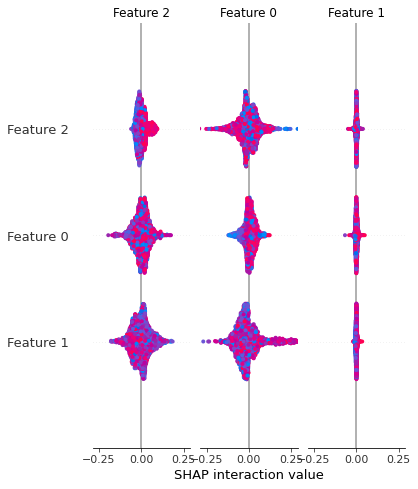

In [66]:
shap.summary_plot(shap_values)

---
## Analysis 2: Time-series classification

See next jupyter notebook

---
## Plot

In [ ]:
# for metric_txt in DICT_DIST_METRICS.keys():

#     ## Data preprocessing for plotting
#     # Take only accuracy for class1 over all runs and delete irrelevant columns
#     plotsdataset = classif_results[( (classif_results['classLabel']==1) & (classif_results['distMetric'] == DICT_DISTMETRIC_TO_NUM[metric_txt]) )]   # Filter for plotting
#     plotsdataset.drop(['mcIter','classLabel','precision','recall'], axis=1, inplace=True)
#     plotsdataset.tail()

#     ## Plot
#     if(experiment_config.SHOW_PLOTS): plot_violin_mc(plotsdataset, x_colname="dataRep", y_colname="accuracy", hue_colname="classifier",\
#                     suptitle=f'Classification accuracy over {MC_ITERATIONS} Monte-Carlo simulations',\
#                     title = f"Distance Measure = {metric_txt}",\
#                     x_ticklabels = experiment_config.HEADERS_DATASETS, \
#                     y_lim=[0,1], \
#                     n_rows=1, n_cols=1, figsize=(8,6), \
#                     save_path=gen_path_plot(f"accuracies_{metric_txt}"),
#                     boxplot_instead_violin=True)

In [ ]:
print(">> FINISHED WITHOUT ERRORS!!")